<a href="https://colab.research.google.com/github/tuesmonsoleil/Dysgraphia-Classification/blob/main/resnet_for_handwriting_0319.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from PIL import Image

In [24]:
# Define data directory
data_dir = "train"
from google.colab import drive
drive.mount('/content/drive')
Dataset = os.chdir('/content/drive/My Drive/Dataset/dataSciRep_public') #切換該目錄
os.listdir() #確認目錄內容

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['test',
 'train',
 'dataset',
 'model_fold5.pth',
 'model_fold1.pth',
 'model_fold2.pth',
 'model_fold3.pth',
 'model_fold4.pth']

In [ ]:
# Определение класса RandomContoursRemovalTransform
class RandomContoursRemovalTransform(object):
    def __init__(self, removal_probability=0.4):
        self.removal_probability = removal_probability

    def __call__(self, img):
        # Convert PIL image to numpy array
        img_np = np.array(img)

        # Convert RGB to Grayscale
        gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Apply threshold using Otsu's method
        _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find contours, remove some, and draw them back onto the RGB image
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_contours_to_remove = int(len(contours) * self.removal_probability)
        contours_to_remove = random.sample(contours, num_contours_to_remove)
        cv2.drawContours(img_np, contours_to_remove, -1, (255, 255, 255), -1)

        return Image.fromarray(img_np)


if __name__ == '__main__':
    print("cuda.is_available " + str(torch.cuda.is_available()))
    # Define data transforms
    transform = transforms.Compose([
        transforms.Resize((400, 400)),
        RandomContoursRemovalTransform(removal_probability=0.4),
        transforms.RandomCrop((224, 224)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Define data directory
    data_dir = "train"
    dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

    # Determine the number of classes in your dataset
    num_classes = len(os.listdir(data_dir))

    # Define hyperparameters
    num_epochs = 40
    learning_rate = 0.001
    batch_size = 4

    # Define cross-validation strategy (e.g., 5-fold)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kf.split(range(len(dataset)), dataset.targets)):
        print(f"Fold {fold + 1}:")

        # Split the dataset into training and validation sets for this fold
        train_dataset = torch.utils.data.Subset(dataset, train_indices)
        val_dataset = torch.utils.data.Subset(dataset, val_indices)

        # Create data loaders for training and validation
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


        # Define the model
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Replace the last fully connected layer
        # ResNet50 uses 2048 features before the final layer
        model.fc = nn.Linear(2048, num_classes)


        # Set the device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Define the loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

        # Training loop
        for epoch in range(num_epochs):
            epoch_start_time = time.time()  # Capture the start time of the epoch
            iterations_start_time = time.time()  # Capture the start time of the iteration

            model.train()
            running_loss = 0.0

            for i, data in enumerate(train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                if i % 10 == 9:
                    iterations_delta_time = time.time() - iterations_start_time  # Calculate the time difference
                    iterations_start_time = time.time()

                    print(f"[{epoch + 1}, {i + 1}], {iterations_delta_time}, loss: {running_loss / 10:.3f}")

                    running_loss = 0.0

            # Validation loop
            model.eval()
            y_true = []
            y_pred = []

            with torch.no_grad():
                for data in val_loader:
                    images, labels = data
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)

                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

            f1 = f1_score(y_true, y_pred, average='weighted')
            epoch_delta_time = time.time() - epoch_start_time  # Calculate the time difference

            print(f"F1 Score (Fold {fold + 1}, Epoch {epoch + 1}, sec {epoch_delta_time}): {f1:.4f}")

        # После обучения модели и вычисления метрик для текущего fold
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Визуализация метрик для текущего fold
        metrics = [precision, recall, f1]
        metric_names = ['Precision', 'Recall', 'F1 Score']
        plt.figure(figsize=(7, 4))
        plt.bar(metric_names, metrics, color=['blue', 'orange', 'green'])
        plt.title(f'Metrics for Fold {fold + 1}')
        plt.ylim([0, 1])
        for i, v in enumerate(metrics):
            plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')
        plt.show(block=False)

        # После обучения модели и вычисления метрик для текущего fold
        model.eval()
        y_true = []
        y_scores = []  # Список для хранения вероятностей классов

        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                images = images.to(device)
                outputs = model(images)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)  # Вычисление вероятностей
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(probabilities[:, 1].cpu().numpy())  # Вероятности класса 1

        # Вычисление ROC-кривой и AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Построение ROC-кривой
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (Fold {fold + 1})')
        plt.legend(loc='lower right')
        plt.show(block=False)

        # Save the model for this fold if needed
        torch.save(model.state_dict(), f"model_fold{fold + 1}.pth")

    input("Press Enter to exit...")

cuda.is_available True
Fold 1:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


[1, 10], 8.915940761566162, loss: 0.745
[1, 20], 6.578901529312134, loss: 0.727


KeyboardInterrupt: 

In [25]:
# Определение класса RandomContoursRemovalTransform
class RandomContoursRemovalTransform(object):
    def __init__(self, removal_probability=0.4):
        self.removal_probability = removal_probability

    def __call__(self, img):
        # Convert PIL image to numpy array
        img_np = np.array(img)

        # Convert RGB to Grayscale
        gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Apply threshold using Otsu's method
        _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find contours, remove some, and draw them back onto the RGB image
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        num_contours_to_remove = int(len(contours) * self.removal_probability)
        contours_to_remove = random.sample(contours, num_contours_to_remove)
        cv2.drawContours(img_np, contours_to_remove, -1, (255, 255, 255), -1)

        return Image.fromarray(img_np)


if __name__ == '__main__':
    print("cuda.is_available " + str(torch.cuda.is_available()))
    # Define data transforms
    transform = transforms.Compose([
        transforms.Resize((400, 400)),
        RandomContoursRemovalTransform(removal_probability=0.4),
        transforms.RandomCrop((224, 224)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        # transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

cuda.is_available True


In [ ]:
import random

# Define the range of parameters to test
learning_rate_range = [0.0001, 0.001, 0.01]
removal_probability_range = [0.2, 0.4, 0.6]

# Define the number of experiments to run
num_experiments = 10

for experiment in range(num_experiments):
    # Randomly select parameters from the defined ranges
    learning_rate = random.choice(learning_rate_range)
    removal_probability = random.choice(removal_probability_range)

    # Define data transforms with the selected removal probability
    transform = transforms.Compose([
        transforms.Resize((400, 400)),
        RandomContoursRemovalTransform(removal_probability=removal_probability),
        transforms.RandomCrop((224, 224)),
        transforms.RandomRotation(3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Print the selected parameters for this experiment
    print(f"Experiment {experiment + 1}:")
    print(f"Learning Rate: {learning_rate}")
    print(f"Removal Probability: {removal_probability}")

    # Define the model and other parameters as before

    # Training loop and evaluation as before

    print("Experiment completed.")


Experiment 1:
Learning Rate: 0.0001
Removal Probability: 0.4
Experiment completed.
Experiment 2:
Learning Rate: 0.01
Removal Probability: 0.4
Experiment completed.
Experiment 3:
Learning Rate: 0.001
Removal Probability: 0.2
Experiment completed.
Experiment 4:
Learning Rate: 0.0001
Removal Probability: 0.2
Experiment completed.
Experiment 5:
Learning Rate: 0.01
Removal Probability: 0.6
Experiment completed.
Experiment 6:
Learning Rate: 0.0001
Removal Probability: 0.2
Experiment completed.
Experiment 7:
Learning Rate: 0.001
Removal Probability: 0.6
Experiment completed.
Experiment 8:
Learning Rate: 0.01
Removal Probability: 0.2
Experiment completed.
Experiment 9:
Learning Rate: 0.0001
Removal Probability: 0.4
Experiment completed.
Experiment 10:
Learning Rate: 0.0001
Removal Probability: 0.2
Experiment completed.


In [ ]:
import os
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def test_model(model_path, test_data_dir):
    # Load the saved model
    model = resnet50()
    num_classes = len(os.listdir(test_data_dir))
    model.fc = nn.Linear(2048, num_classes)
    model.load_state_dict(torch.load(model_path))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Define test transform
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the same size used in training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    batch_size = 4

    # Load test data
    test_dataset = torchvision.datasets.ImageFolder(root=test_data_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate F1 score and accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

if __name__=="__main__":
    # Example usage:
    test_model(model_path="model_fold3.pth", test_data_dir="test")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


F1 Score: 0.3333
Accuracy: 0.5000


In [1]:
!pip install protobuf==3.20.3
!pip install --upgrade tensorflow-metadata

In [2]:
!pip install -q flwr[simulation] torch torchvision scipy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.


In [3]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.2.1+cu121 and Flower 1.7.0


In [4]:
NUM_CLIENTS = 2


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 20  # 20 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=40, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=40))
    testloader = DataLoader(testset, batch_size=40)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100%|██████████| 170498071/170498071 [00:12<00:00, 13157495.61it/s]


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset
Files already downloaded and verified


In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
class FlowerNumPyClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def numpyclient_fn(cid) -> FlowerNumPyClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerNumPyClient(cid, net, trainloader, valloader)

In [7]:
# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

fl.simulation.start_simulation(
    client_fn=numpyclient_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    client_resources=client_resources,
)

import matplotlib.pyplot as plt

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()

    # Initialize lists to store training loss and accuracy
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        # Calculate and store training accuracy for this epoch
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

    # Plot training loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

INFO flwr 2024-03-19 12:28:01,746 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-03-19 12:28:08,707	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-19 12:28:11,870 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3911297433.0, 'CPU': 2.0, 'memory': 7822594868.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3911297433.0, 'CPU': 2.0, 'memory': 7822594868.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2024-03-19 12:28:11,875 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=13645) [Client 1] get_parameters
(DefaultActor pid=13645) [Client 1] fit, config: {}
(DefaultActor pid=13644) [Client 0] fit, config: {}


(pid=13644) 2024-03-19 12:28:23.192325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(DefaultActor pid=13644) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=13644)   client = check_clientfn_returns_client(client_fn(cid))


(DefaultActor pid=13645) Epoch 1: train loss 0.044192105531692505, accuracy 0.34981052631578946


DEBUG flwr 2024-03-19 12:28:58,769 | server.py:236 | fit_round 1 received 2 results and 0 failures
DEBUG:flwr:fit_round 1 received 2 results and 0 failures
WARNING flwr 2024-03-19 12:28:58,779 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2024-03-19 12:28:58,781 | server.py:173 | evaluate_round 1: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 1: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13644) Epoch 1: train loss 0.04486335441470146, accuracy 0.3330105263157895
(DefaultActor pid=13644) [Client 1] evaluate, config: {}


DEBUG flwr 2024-03-19 12:29:02,242 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2024-03-19 12:29:02,245 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-03-19 12:29:02,247 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13645) [Client 0] fit, config: {}
(DefaultActor pid=13645) [Client 0] evaluate, config: {}
(DefaultActor pid=13645) Epoch 1: train loss 0.03834744915366173, accuracy 0.4415578947368421
(DefaultActor pid=13644) [Client 1] fit, config: {}


DEBUG flwr 2024-03-19 12:29:30,402 | server.py:236 | fit_round 2 received 2 results and 0 failures
DEBUG:flwr:fit_round 2 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:29:30,413 | server.py:173 | evaluate_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13644) [Client 1] evaluate, config: {}


DEBUG flwr 2024-03-19 12:29:34,584 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:29:34,588 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13645) [Client 0] fit, config: {}
(DefaultActor pid=13644) Epoch 1: train loss 0.038280632346868515, accuracy 0.4422315789473684
(DefaultActor pid=13645) [Client 0] evaluate, config: {}
(DefaultActor pid=13645) Epoch 1: train loss 0.034401219338178635, accuracy 0.5058526315789473
(DefaultActor pid=13644) [Client 1] fit, config: {}


DEBUG flwr 2024-03-19 12:30:02,349 | server.py:236 | fit_round 3 received 2 results and 0 failures
DEBUG:flwr:fit_round 3 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:30:02,358 | server.py:173 | evaluate_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13644) [Client 0] evaluate, config: {}
(DefaultActor pid=13644) Epoch 1: train loss 0.034398164600133896, accuracy 0.5011789473684211


DEBUG flwr 2024-03-19 12:30:06,744 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:30:06,746 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13645) [Client 0] fit, config: {}
(DefaultActor pid=13645) [Client 1] evaluate, config: {}
(DefaultActor pid=13645) Epoch 1: train loss 0.03225094452500343, accuracy 0.5386526315789474
(DefaultActor pid=13644) [Client 1] fit, config: {}


DEBUG flwr 2024-03-19 12:30:35,669 | server.py:236 | fit_round 4 received 2 results and 0 failures
DEBUG:flwr:fit_round 4 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:30:35,679 | server.py:173 | evaluate_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 4: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13644) [Client 0] evaluate, config: {}
(DefaultActor pid=13644) Epoch 1: train loss 0.03212498500943184, accuracy 0.5399578947368421


DEBUG flwr 2024-03-19 12:30:38,929 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:30:38,934 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13645) [Client 1] fit, config: {}
(DefaultActor pid=13645) Epoch 1: train loss 0.03039969690144062, accuracy 0.5657263157894736
(DefaultActor pid=13645) [Client 1] evaluate, config: {}
(DefaultActor pid=13644) [Client 0] fit, config: {}


DEBUG flwr 2024-03-19 12:31:08,831 | server.py:236 | fit_round 5 received 2 results and 0 failures
DEBUG:flwr:fit_round 5 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:31:08,842 | server.py:173 | evaluate_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:evaluate_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=13644) [Client 0] evaluate, config: {}


DEBUG flwr 2024-03-19 12:31:12,146 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
INFO flwr 2024-03-19 12:31:12,150 | server.py:153 | FL finished in 164.23594544200023
INFO:flwr:FL finished in 164.23594544200023
INFO flwr 2024-03-19 12:31:12,154 | app.py:226 | app_fit: losses_distributed [(1, 0.049230372524261476), (2, 0.035715474367141724), (3, 0.033371635341644286), (4, 0.030894998836517334), (5, 0.029738425254821777)]
INFO:flwr:app_fit: losses_distributed [(1, 0.049230372524261476), (2, 0.035715474367141724), (3, 0.033371635341644286), (4, 0.030894998836517334), (5, 0.029738425254821777)]
INFO flwr 2024-03-19 12:31:12,157 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2024-03-19 12:31:12,159 | app.py:228 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2024-03-19 12:31:12,161 | app.py:229 | app_fit: losse

In [8]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)


class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.cid}] get_parameters")

        # Get parameters as a list of NumPy ndarray's
        ndarrays: List[np.ndarray] = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object
        parameters = ndarrays_to_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.net, ndarrays_original)
        train(self.net, self.trainloader, epochs=5)
        ndarrays_updated = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"[Client {self.cid}] evaluate, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        set_parameters(self.net, ndarrays_original)
        loss, accuracy = test(self.net, self.valloader)
        # return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader),
            metrics={"accuracy": float(accuracy)},
        )


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


INFO flwr 2024-03-19 12:31:12,209 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-03-19 12:31:16,430	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-19 12:31:19,887 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7822260635.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3911130316.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7822260635.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3911130316.0}
INFO flwr 2024-03-19 12:31:19,894 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=14654) [Client 0] get_parameters
(DefaultActor pid=14654) [Client 1] fit, config: {}
(DefaultActor pid=14653) [Client 0] fit, config: {}
(DefaultActor pid=14654) Epoch 1: train loss 0.04434491693973541, accuracy 0.34821052631578947
(DefaultActor pid=14653) Epoch 1: train loss 0.04425583779811859, accuracy 0.3503578947368421
(DefaultActor pid=14654) Epoch 2: train loss 0.03753343224525452, accuracy 0.4558315789473684
(DefaultActor pid=14653) Epoch 2: train loss 0.03737222030758858, accuracy 0.4521263157894737
(DefaultActor pid=14654) Epoch 3: train loss 0.03472491353750229, accuracy 0.4968842105263158
(DefaultActor pid=14653) Epoch 3: train loss 0.034336771816015244, accuracy 0.5034526315789474
(DefaultActor pid=14654) Epoch 4: train loss 0.032746799290180206, accuracy 0.5277052631578948
(DefaultActor pid=14653) Epoch 4: train loss 0.03202486038208008, accuracy 0.5391578947368421


(DefaultActor pid=14654) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(DefaultActor pid=14654) given by the platformdirs library.  To remove this warning and
(DefaultActor pid=14654) see the appropriate new directories, set the environment variable
(DefaultActor pid=14654) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(DefaultActor pid=14654) The use of platformdirs will be the default in `jupyter_core` v6
(DefaultActor pid=14654)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(pid=14653) 2024-03-19 12:31:23.556895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14653) 2024-03-19 12:31:23.556951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Att

(DefaultActor pid=14654) Epoch 5: train loss 0.03102795220911503, accuracy 0.5501894736842106


ERROR flwr 2024-03-19 12:33:43,178 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14653) [Client 0] evaluate, config: {}
(DefaultActor pid=14653) Epoch 5: train loss 0.030257804319262505, accuracy 0.5653894736842106


DEBUG flwr 2024-03-19 12:33:46,574 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2024-03-19 12:33:46,577 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-03-19 12:33:46,579 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=14654) [Client 0] fit, config: {}
(DefaultActor pid=14654) Epoch 1: train loss 0.044431865215301514, accuracy 0.3413894736842105
(DefaultActor pid=14654) [Client 1] evaluate, config: {}
(DefaultActor pid=14653) [Client 1] fit, config: {}
(DefaultActor pid=14653) Epoch 2: train loss 0.03762032836675644, accuracy 0.4514947368421053 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(DefaultActor pid=14653) Epoch 3: train loss 0.034878332167863846, accuracy 0.4928421052631579 [repeated 2x across cluster]
(DefaultActor pid=14653) Epoch 4: train loss 0.03302692621946335, accuracy 0.5230736842105264 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:36:00,672 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14653) Epoch 5: train loss 0.031212031841278076, accuracy 0.5498105263157895 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:36:00,942 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14654) [Client 1] evaluate, config: {}


DEBUG flwr 2024-03-19 12:36:04,275 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:36:04,279 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=14653) [Client 1] fit, config: {}
(DefaultActor pid=14654) Epoch 5: train loss 0.030516210943460464, accuracy 0.5633684210526316
(DefaultActor pid=14653) Epoch 1: train loss 0.04488502815365791, accuracy 0.3389052631578947
(DefaultActor pid=14653) [Client 0] evaluate, config: {}
(DefaultActor pid=14654) [Client 0] fit, config: {}
(DefaultActor pid=14653) Epoch 2: train loss 0.03730085492134094, accuracy 0.4584 [repeated 2x across cluster]
(DefaultActor pid=14653) Epoch 3: train loss 0.03407565876841545, accuracy 0.5061894736842105 [repeated 2x across cluster]
(DefaultActor pid=14653) Epoch 4: train loss 0.031783055514097214, accuracy 0.5444631578947369 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:38:15,624 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14653) Epoch 5: train loss 0.02994428761303425, accuracy 0.5739368421052632 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:38:16,088 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14654) [Client 0] evaluate, config: {}


DEBUG flwr 2024-03-19 12:38:19,472 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:38:19,475 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)


(DefaultActor pid=14653) [Client 0] fit, config: {}
(DefaultActor pid=14654) Epoch 5: train loss 0.03080182708799839, accuracy 0.5569684210526316
(DefaultActor pid=14653) Epoch 1: train loss 0.04468883201479912, accuracy 0.34046315789473686
(DefaultActor pid=14653) [Client 1] evaluate, config: {}
(DefaultActor pid=14654) [Client 1] fit, config: {}
(DefaultActor pid=14653) Epoch 2: train loss 0.037346359342336655, accuracy 0.4529263157894737 [repeated 2x across cluster]
(DefaultActor pid=14653) Epoch 3: train loss 0.03419792279601097, accuracy 0.5078315789473684 [repeated 2x across cluster]
(DefaultActor pid=14653) Epoch 4: train loss 0.03190082311630249, accuracy 0.5414736842105263 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:40:33,273 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14653) Epoch 5: train loss 0.029995301738381386, accuracy 0.5741894736842105 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:40:34,375 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14654) [Client 0] evaluate, config: {}


DEBUG flwr 2024-03-19 12:40:37,681 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:40:37,684 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=14653) [Client 1] fit, config: {}
(DefaultActor pid=14654) Epoch 5: train loss 0.030801765620708466, accuracy 0.5581894736842106
(DefaultActor pid=14653) Epoch 1: train loss 0.04417610168457031, accuracy 0.3510315789473684
(DefaultActor pid=14653) [Client 1] evaluate, config: {}
(DefaultActor pid=14654) [Client 0] fit, config: {}
(DefaultActor pid=14653) Epoch 2: train loss 0.03744468465447426, accuracy 0.4567578947368421 [repeated 2x across cluster]
(DefaultActor pid=14653) Epoch 3: train loss 0.03461591526865959, accuracy 0.49962105263157897 [repeated 2x across cluster]
(DefaultActor pid=14653) Epoch 4: train loss 0.03243434801697731, accuracy 0.5354526315789474 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:42:51,560 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14653) Epoch 5: train loss 0.030728712677955627, accuracy 0.5594105263157895 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:42:52,781 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=14654) [Client 1] evaluate, config: {}


DEBUG flwr 2024-03-19 12:42:56,087 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
INFO flwr 2024-03-19 12:42:56,090 | server.py:153 | FL finished in 685.7667132800002
INFO:flwr:FL finished in 685.7667132800002
INFO flwr 2024-03-19 12:42:56,091 | app.py:226 | app_fit: losses_distributed [(1, 0.058992417621612545), (2, 0.058992417621612545), (3, 0.058992417621612545), (4, 0.058992417621612545), (5, 0.058992417621612545)]
INFO:flwr:app_fit: losses_distributed [(1, 0.058992417621612545), (2, 0.058992417621612545), (3, 0.058992417621612545), (4, 0.058992417621612545), (5, 0.058992417621612545)]
INFO flwr 2024-03-19 12:42:56,094 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2024-03-19 12:42:56,095 | app.py:228 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2024-03-19 12:42:56,097 | app.py:229 | app_fit: losses_

NameError: name 'epochs' is not defined

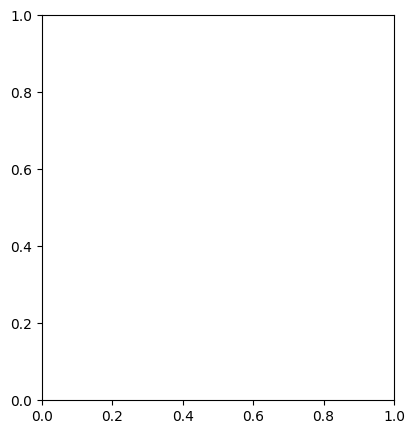

In [9]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    client_resources=client_resources,
)


In [10]:
class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.train_losses = []  # 用來儲存訓練損失的列表
        self.train_accuracies = []  # 用來儲存訓練準確率的列表

    # 其他方法保持不變

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's
        parameters_original = ins.parameters
        ndarrays_original = parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.net, ndarrays_original)
        train(self.net, self.trainloader, epochs=5, client_id=self.cid)
        ndarrays_updated = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)

        # Plot training loss and accuracy
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        for i, losses in enumerate(self.train_losses):
            plt.plot(range(1, len(losses) + 1), losses, label=f'Epoch {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Client {self.cid} Training Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        for i, accuracies in enumerate(self.train_accuracies):
            plt.plot(range(1, len(accuracies) + 1), accuracies, label=f'Epoch {i+1}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Client {self.cid} Training Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

In [11]:
from io import BytesIO
from typing import cast

import numpy as np

from flwr.common.typing import NDArray, NDArrays, Parameters


def ndarrays_to_sparse_parameters(ndarrays: NDArrays) -> Parameters:
    """Convert NumPy ndarrays to parameters object."""
    tensors = [ndarray_to_sparse_bytes(ndarray) for ndarray in ndarrays]
    return Parameters(tensors=tensors, tensor_type="numpy.ndarray")


def sparse_parameters_to_ndarrays(parameters: Parameters) -> NDArrays:
    """Convert parameters object to NumPy ndarrays."""
    return [sparse_bytes_to_ndarray(tensor) for tensor in parameters.tensors]


def ndarray_to_sparse_bytes(ndarray: NDArray) -> bytes:
    """Serialize NumPy ndarray to bytes."""
    bytes_io = BytesIO()

    if len(ndarray.shape) > 1:
        # We convert our ndarray into a sparse matrix
        ndarray = torch.tensor(ndarray).to_sparse_csr()

        # And send it byutilizing the sparse matrix attributes
        # WARNING: NEVER set allow_pickle to true.
        # Reason: loading pickled data can execute arbitrary code
        # Source: https://numpy.org/doc/stable/reference/generated/numpy.save.html
        np.savez(
            bytes_io,  # type: ignore
            crow_indices=ndarray.crow_indices(),
            col_indices=ndarray.col_indices(),
            values=ndarray.values(),
            allow_pickle=False,
        )
    else:
        # WARNING: NEVER set allow_pickle to true.
        # Reason: loading pickled data can execute arbitrary code
        # Source: https://numpy.org/doc/stable/reference/generated/numpy.save.html
        np.save(bytes_io, ndarray, allow_pickle=False)
    return bytes_io.getvalue()


def sparse_bytes_to_ndarray(tensor: bytes) -> NDArray:
    """Deserialize NumPy ndarray from bytes."""
    bytes_io = BytesIO(tensor)
    # WARNING: NEVER set allow_pickle to true.
    # Reason: loading pickled data can execute arbitrary code
    # Source: https://numpy.org/doc/stable/reference/generated/numpy.load.html
    loader = np.load(bytes_io, allow_pickle=False)  # type: ignore

    if "crow_indices" in loader:
        # We convert our sparse matrix back to a ndarray, using the attributes we sent
        ndarray_deserialized = (
            torch.sparse_csr_tensor(
                crow_indices=loader["crow_indices"],
                col_indices=loader["col_indices"],
                values=loader["values"],
            )
            .to_dense()
            .numpy()
        )
    else:
        ndarray_deserialized = loader
    return cast(NDArray, ndarray_deserialized)

In [12]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
)


class FlowerClient(fl.client.Client):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, ins: GetParametersIns) -> GetParametersRes:
        print(f"[Client {self.cid}] get_parameters")

        # Get parameters as a list of NumPy ndarray's
        ndarrays: List[np.ndarray] = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object using our custom function
        parameters = ndarrays_to_sparse_parameters(ndarrays)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return GetParametersRes(
            status=status,
            parameters=parameters,
        )

    def fit(self, ins: FitIns) -> FitRes:
        print(f"[Client {self.cid}] fit, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's using our custom function
        parameters_original = ins.parameters
        ndarrays_original = sparse_parameters_to_ndarrays(parameters_original)

        # Update local model, train, get updated parameters
        set_parameters(self.net, ndarrays_original)
        train(self.net, self.trainloader, epochs=10)
        ndarrays_updated = get_parameters(self.net)

        # Serialize ndarray's into a Parameters object using our custom function
        parameters_updated = ndarrays_to_sparse_parameters(ndarrays_updated)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        print(f"[Client {self.cid}] evaluate, config: {ins.config}")

        # Deserialize parameters to NumPy ndarray's using our custom function
        parameters_original = ins.parameters
        ndarrays_original = sparse_parameters_to_ndarrays(parameters_original)

        set_parameters(self.net, ndarrays_original)
        loss, accuracy = test(self.net, self.valloader)

        # Build and return response
        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader),
            metrics={"accuracy": float(accuracy)},
        )


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [13]:
from logging import WARNING
from typing import Callable, Dict, List, Optional, Tuple, Union

from flwr.common import FitRes, MetricsAggregationFn, NDArrays, Parameters, Scalar
from flwr.common.logger import log
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy import FedAvg
from flwr.server.strategy.aggregate import aggregate

WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW = """
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.
"""


class FedSparse(FedAvg):
    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, Dict[str, Scalar]],
                Optional[Tuple[float, Dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
    ) -> None:
        """Custom FedAvg strategy with sparse matrices.

        Parameters
        ----------
        fraction_fit : float, optional
            Fraction of clients used during training. Defaults to 0.1.
        fraction_evaluate : float, optional
            Fraction of clients used during validation. Defaults to 0.1.
        min_fit_clients : int, optional
            Minimum number of clients used during training. Defaults to 2.
        min_evaluate_clients : int, optional
            Minimum number of clients used during validation. Defaults to 2.
        min_available_clients : int, optional
            Minimum number of total clients in the system. Defaults to 2.
        evaluate_fn : Optional[Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]]
            Optional function used for validation. Defaults to None.
        on_fit_config_fn : Callable[[int], Dict[str, Scalar]], optional
            Function used to configure training. Defaults to None.
        on_evaluate_config_fn : Callable[[int], Dict[str, Scalar]], optional
            Function used to configure validation. Defaults to None.
        accept_failures : bool, optional
            Whether or not accept rounds containing failures. Defaults to True.
        initial_parameters : Parameters, optional
            Initial global model parameters.
        """

        if (
            min_fit_clients > min_available_clients
            or min_evaluate_clients > min_available_clients
        ):
            log(WARNING, WARNING_MIN_AVAILABLE_CLIENTS_TOO_LOW)

        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None

        # We deserialize using our custom method
        parameters_ndarrays = sparse_parameters_to_ndarrays(parameters)

        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        if not results:
            return None, {}
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # We deserialize each of the results with our custom method
        weights_results = [
            (sparse_parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        # We serialize the aggregated result using our custom method
        parameters_aggregated = ndarrays_to_sparse_parameters(
            aggregate(weights_results)
        )

        # Aggregate custom metrics if aggregation fn was provided
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        elif server_round == 1:  # Only log this warning once
            log(WARNING, "No fit_metrics_aggregation_fn provided")

        return parameters_aggregated, metrics_aggregated

In [14]:
strategy = FedSparse()

fl.simulation.start_simulation(
    strategy=strategy,
    client_fn=client_fn,
    num_clients=2,
    config=fl.server.ServerConfig(num_rounds=5),
    client_resources=client_resources,
)

INFO flwr 2024-03-19 12:44:38,230 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-03-19 12:44:45,854	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-19 12:44:48,019 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3912039628.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7824079259.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3912039628.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7824079259.0, 'CPU': 2.0}
INFO flwr 2024-03-19 12:44:48,026 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=18307) [Client 1] get_parameters


(DefaultActor pid=18307) <ipython-input-11-77ba978efaa6>:26: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
(pid=18306) 2024-03-19 12:44:51.251024: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18306) 2024-03-19 12:44:51.251094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18306) 2024-03-19 12:44:51.252852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid

(DefaultActor pid=18307) [Client 1] fit, config: {}


(DefaultActor pid=18306) <ipython-input-11-77ba978efaa6>:58: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)


(DefaultActor pid=18306) [Client 0] fit, config: {}
(DefaultActor pid=18307) Epoch 1: train loss 0.04411674663424492, accuracy 0.34829473684210527
(DefaultActor pid=18306) Epoch 1: train loss 0.04412034898996353, accuracy 0.3481263157894737
(DefaultActor pid=18307) Epoch 2: train loss 0.03647560998797417, accuracy 0.46757894736842104
(DefaultActor pid=18306) Epoch 2: train loss 0.03689597547054291, accuracy 0.4640421052631579
(DefaultActor pid=18307) Epoch 3: train loss 0.033410221338272095, accuracy 0.5141894736842105
(DefaultActor pid=18306) Epoch 3: train loss 0.03368740156292915, accuracy 0.5170526315789473
(DefaultActor pid=18307) Epoch 4: train loss 0.031120607629418373, accuracy 0.5514526315789474
(DefaultActor pid=18306) Epoch 4: train loss 0.031563881784677505, accuracy 0.5477473684210526
(DefaultActor pid=18307) Epoch 5: train loss 0.02919490821659565, accuracy 0.5818947368421052
(DefaultActor pid=18306) Epoch 5: train loss 0.029865706339478493, accuracy 0.5704421052631579
(D

(DefaultActor pid=18307) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(DefaultActor pid=18307) given by the platformdirs library.  To remove this warning and
(DefaultActor pid=18307) see the appropriate new directories, set the environment variable
(DefaultActor pid=18307) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(DefaultActor pid=18307) The use of platformdirs will be the default in `jupyter_core` v6
(DefaultActor pid=18307)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
ERROR flwr 2024-03-19 12:49:20,104 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulat

(DefaultActor pid=18307) Epoch 10: train loss 0.022696126252412796, accuracy 0.6781894736842106


(DefaultActor pid=18306) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(DefaultActor pid=18306) given by the platformdirs library.  To remove this warning and
(DefaultActor pid=18306) see the appropriate new directories, set the environment variable
(DefaultActor pid=18306) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(DefaultActor pid=18306) The use of platformdirs will be the default in `jupyter_core` v6
(DefaultActor pid=18306)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
ERROR flwr 2024-03-19 12:49:25,733 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulat

(DefaultActor pid=18306) Epoch 10: train loss 0.02388530597090721, accuracy 0.6563368421052631
(DefaultActor pid=18306) [Client 1] evaluate, config: {}


DEBUG flwr 2024-03-19 12:49:30,940 | server.py:187 | evaluate_round 1 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2024-03-19 12:49:30,944 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-03-19 12:49:30,946 | server.py:222 | fit_round 2: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 2: strategy sampled 2 clients (out of 2)


(DefaultActor pid=18307) [Client 1] fit, config: {}
(DefaultActor pid=18307) [Client 0] evaluate, config: {}
(DefaultActor pid=18307) Epoch 1: train loss 0.04477623850107193, accuracy 0.3433263157894737
(DefaultActor pid=18306) [Client 0] fit, config: {}
(DefaultActor pid=18307) Epoch 2: train loss 0.03703273832798004, accuracy 0.4623578947368421 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 3: train loss 0.033938005566596985, accuracy 0.5102736842105263 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 4: train loss 0.03142790123820305, accuracy 0.5461894736842106 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 5: train loss 0.02951166406273842, accuracy 0.5768842105263158 [repeated 2x across cluster]
(DefaultActor pid=18306) Epoch 5: train loss 0.030350947752594948, accuracy 0.5684210526315789
(DefaultActor pid=18307) Epoch 6: train loss 0.027804579585790634, accuracy 0.6031578947368421
(DefaultActor pid=18307) Epoch 7: train loss 0.026394847780466

ERROR flwr 2024-03-19 12:54:08,319 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18307) Epoch 10: train loss 0.022856617346405983, accuracy 0.6778105263157894 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:54:10,632 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18306) [Client 1] evaluate, config: {}
(DefaultActor pid=18306) Epoch 10: train loss 0.02407350391149521, accuracy 0.6592421052631579


DEBUG flwr 2024-03-19 12:54:14,047 | server.py:187 | evaluate_round 2 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:54:14,050 | server.py:222 | fit_round 3: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 3: strategy sampled 2 clients (out of 2)


(DefaultActor pid=18307) [Client 0] fit, config: {}
(DefaultActor pid=18307) Epoch 1: train loss 0.04404653608798981, accuracy 0.3506947368421053
(DefaultActor pid=18307) [Client 0] evaluate, config: {}
(DefaultActor pid=18306) [Client 1] fit, config: {}
(DefaultActor pid=18307) Epoch 2: train loss 0.03666466474533081, accuracy 0.46812631578947367 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 3: train loss 0.03376957029104233, accuracy 0.5138526315789473 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 4: train loss 0.03144724667072296, accuracy 0.5474105263157895 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 5: train loss 0.02968747913837433, accuracy 0.5766736842105263 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 6: train loss 0.028244752436876297, accuracy 0.5984421052631579 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 7: train loss 0.026814088225364685, accuracy 0.6183578947368421 [repeated 2x across cluster]
(Def

ERROR flwr 2024-03-19 12:58:31,875 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18307) Epoch 10: train loss 0.02341749146580696, accuracy 0.6669894736842106 [repeated 2x across cluster]


ERROR flwr 2024-03-19 12:58:34,020 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18306) [Client 0] evaluate, config: {}
(DefaultActor pid=18306) Epoch 10: train loss 0.022186558693647385, accuracy 0.685178947368421


DEBUG flwr 2024-03-19 12:58:38,391 | server.py:187 | evaluate_round 3 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2024-03-19 12:58:38,394 | server.py:222 | fit_round 4: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 4: strategy sampled 2 clients (out of 2)


(DefaultActor pid=18307) [Client 1] fit, config: {}
(DefaultActor pid=18307) Epoch 1: train loss 0.043891988694667816, accuracy 0.35418947368421055
(DefaultActor pid=18307) [Client 1] evaluate, config: {}
(DefaultActor pid=18306) [Client 0] fit, config: {}
(DefaultActor pid=18307) Epoch 2: train loss 0.036880649626255035, accuracy 0.4624421052631579 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 3: train loss 0.03389620780944824, accuracy 0.5040421052631578 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 4: train loss 0.03190350905060768, accuracy 0.5397894736842105 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 5: train loss 0.030205899849534035, accuracy 0.5644631578947369 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 6: train loss 0.028650803491473198, accuracy 0.5916210526315789 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 7: train loss 0.027304163202643394, accuracy 0.6099789473684211 [repeated 2x across cluster]
(

ERROR flwr 2024-03-19 13:02:56,595 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18307) Epoch 10: train loss 0.023695744574069977, accuracy 0.6634526315789474 [repeated 2x across cluster]


ERROR flwr 2024-03-19 13:02:58,328 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18306) [Client 1] evaluate, config: {}
(DefaultActor pid=18306) Epoch 10: train loss 0.022984014824032784, accuracy 0.6731789473684211


DEBUG flwr 2024-03-19 13:03:02,624 | server.py:187 | evaluate_round 4 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2024-03-19 13:03:02,627 | server.py:222 | fit_round 5: strategy sampled 2 clients (out of 2)
DEBUG:flwr:fit_round 5: strategy sampled 2 clients (out of 2)


(DefaultActor pid=18307) [Client 0] fit, config: {}
(DefaultActor pid=18307) [Client 0] evaluate, config: {}
(DefaultActor pid=18307) Epoch 1: train loss 0.04387487843632698, accuracy 0.3496421052631579
(DefaultActor pid=18306) [Client 1] fit, config: {}
(DefaultActor pid=18307) Epoch 2: train loss 0.036769378930330276, accuracy 0.46227368421052634 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 3: train loss 0.033647570759058, accuracy 0.5100631578947369 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 4: train loss 0.031661272048950195, accuracy 0.5450105263157895 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 5: train loss 0.02996930293738842, accuracy 0.5696842105263158 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 6: train loss 0.028438899666070938, accuracy 0.5946947368421053 [repeated 2x across cluster]
(DefaultActor pid=18307) Epoch 7: train loss 0.027052877470850945, accuracy 0.6148210526315789 [repeated 2x across cluster]
(Def

ERROR flwr 2024-03-19 13:07:20,789 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18307) Epoch 10: train loss 0.023699093610048294, accuracy 0.6644631578947369 [repeated 2x across cluster]


ERROR flwr 2024-03-19 13:07:22,039 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

(DefaultActor pid=18306) [Client 1] evaluate, config: {}


DEBUG flwr 2024-03-19 13:07:25,475 | server.py:187 | evaluate_round 5 received 2 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 2 results and 0 failures
INFO flwr 2024-03-19 13:07:25,478 | server.py:153 | FL finished in 1345.2594265850003
INFO:flwr:FL finished in 1345.2594265850003
INFO flwr 2024-03-19 13:07:25,480 | app.py:226 | app_fit: losses_distributed [(1, 0.059027019691467286), (2, 0.059027019691467286), (3, 0.059027019691467286), (4, 0.059027019691467286), (5, 0.059027019691467286)]
INFO:flwr:app_fit: losses_distributed [(1, 0.059027019691467286), (2, 0.059027019691467286), (3, 0.059027019691467286), (4, 0.059027019691467286), (5, 0.059027019691467286)]
INFO flwr 2024-03-19 13:07:25,481 | app.py:227 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2024-03-19 13:07:25,483 | app.py:228 | app_fit: metrics_distributed {}
INFO:flwr:app_fit: metrics_distributed {}
INFO flwr 2024-03-19 13:07:25,486 | app.py:229 | app_fit: losse

History (loss, distributed):
	round 1: 0.059027019691467286
	round 2: 0.059027019691467286
	round 3: 0.059027019691467286
	round 4: 0.059027019691467286
	round 5: 0.059027019691467286

another framework

In [15]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import torch
from torch import nn, autograd
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from sklearn import metrics


class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label


class LocalUpdate(object):
    def __init__(self, args, dataset=None, idxs=None):
        self.args = args
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=self.args.local_bs, shuffle=True)

    def train(self, net):
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=self.args.lr, momentum=self.args.momentum)

        epoch_loss = []
        for iter in range(self.args.local_ep):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.args.device), labels.to(self.args.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                if self.args.verbose and batch_idx % 10 == 0:
                    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

In [16]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import torch
from torch import nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return x


class CNNMnist(nn.Module):
    def __init__(self, args):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(args.num_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, args.num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


class CNNCifar(nn.Module):
    def __init__(self, args):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import copy
import torch
from torch import nn


def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @python: 3.6

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args.gpu != -1:
            data, target = data.cuda(), target.cuda()
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args.verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [10]:
! pip install utils
! pip install Options

In [2]:
! pip install Nets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 2.2 MB/s eta 0:00:00


In [8]:
! pip install django-model-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 34.0 MB/s eta 0:00:00


In [12]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms

from utils import args_parser
from models.Nets import MLP, CNNMnist, CNNCifar


def test(net_g, data_loader):
    # testing
    net_g.eval()
    test_loss = 0
    correct = 0
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        data, target = data.to(args.device), target.to(args.device)
        log_probs = net_g(data)
        test_loss += F.cross_entropy(log_probs, target).item()
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

    return correct, test_loss


if __name__ == '__main__':
    # parse args
    args = args_parser()
    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    torch.manual_seed(args.seed)

    # load dataset and split users
    if args.dataset == 'mnist':
        dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
        img_size = dataset_train[0][0].shape
    elif args.dataset == 'cifar':
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset_train = datasets.CIFAR10('./data/cifar', train=True, transform=transform, target_transform=None, download=True)
        img_size = dataset_train[0][0].shape
    else:
        exit('Error: unrecognized dataset')

    # build model
    if args.model == 'cnn' and args.dataset == 'cifar':
        net_glob = CNNCifar(args=args).to(args.device)
    elif args.model == 'cnn' and args.dataset == 'mnist':
        net_glob = CNNMnist(args=args).to(args.device)
    elif args.model == 'mlp':
        len_in = 1
        for x in img_size:
            len_in *= x
        net_glob = MLP(dim_in=len_in, dim_hidden=64, dim_out=args.num_classes).to(args.device)
    else:
        exit('Error: unrecognized model')
    print(net_glob)

    # training
    optimizer = optim.SGD(net_glob.parameters(), lr=args.lr, momentum=args.momentum)
    train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)

    list_loss = []
    net_glob.train()
    for epoch in range(args.epochs):
        batch_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(args.device), target.to(args.device)
            optimizer.zero_grad()
            output = net_glob(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))
            batch_loss.append(loss.item())
        loss_avg = sum(batch_loss)/len(batch_loss)
        print('\nTrain loss:', loss_avg)
        list_loss.append(loss_avg)

    # plot loss
    plt.figure()
    plt.plot(range(len(list_loss)), list_loss)
    plt.xlabel('epochs')
    plt.ylabel('train loss')
    plt.savefig('./log/nn_{}_{}_{}.png'.format(args.dataset, args.model, args.epochs))

    # testing
    if args.dataset == 'mnist':
        dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
        test_loader = DataLoader(dataset_test, batch_size=1000, shuffle=False)
    elif args.dataset == 'cifar':
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset_test = datasets.CIFAR10('./data/cifar', train=False, transform=transform, target_transform=None, download=True)
        test_loader = DataLoader(dataset_test, batch_size=1000, shuffle=False)
    else:
        exit('Error: unrecognized dataset')

    print('test on', len(dataset_test), 'samples')
    test_acc, test_loss = test(net_glob, test_loader)

ModuleNotFoundError: No module named 'models'

In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg
from models.test import test_img


if __name__ == '__main__':
    # parse args
    args = args_parser()
    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    # load dataset and split users
    if args.dataset == 'mnist':
        trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
        dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
        # sample users
        if args.iid:
            dict_users = mnist_iid(dataset_train, args.num_users)
        else:
            dict_users = mnist_noniid(dataset_train, args.num_users)
    elif args.dataset == 'cifar':
        trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
        dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
        if args.iid:
            dict_users = cifar_iid(dataset_train, args.num_users)
        else:
            exit('Error: only consider IID setting in CIFAR10')
    else:
        exit('Error: unrecognized dataset')
    img_size = dataset_train[0][0].shape

    # build model
    if args.model == 'cnn' and args.dataset == 'cifar':
        net_glob = CNNCifar(args=args).to(args.device)
    elif args.model == 'cnn' and args.dataset == 'mnist':
        net_glob = CNNMnist(args=args).to(args.device)
    elif args.model == 'mlp':
        len_in = 1
        for x in img_size:
            len_in *= x
        net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
    else:
        exit('Error: unrecognized model')
    print(net_glob)
    net_glob.train()

    # copy weights
    w_glob = net_glob.state_dict()

    # training
    loss_train = []
    cv_loss, cv_acc = [], []
    val_loss_pre, counter = 0, 0
    net_best = None
    best_loss = None
    val_acc_list, net_list = [], []

    if args.all_clients:
        print("Aggregation over all clients")
        w_locals = [w_glob for i in range(args.num_users)]
    for iter in range(args.epochs):
        loss_locals = []
        if not args.all_clients:
            w_locals = []
        m = max(int(args.frac * args.num_users), 1)
        idxs_users = np.random.choice(range(args.num_users), m, replace=False)
        for idx in idxs_users:
            local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
            w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
            if args.all_clients:
                w_locals[idx] = copy.deepcopy(w)
            else:
                w_locals.append(copy.deepcopy(w))
            loss_locals.append(copy.deepcopy(loss))
        # update global weights
        w_glob = FedAvg(w_locals)

        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
        loss_avg = sum(loss_locals) / len(loss_locals)
        print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
        loss_train.append(loss_avg)

    # plot loss curve
    plt.figure()
    plt.plot(range(len(loss_train)), loss_train)
    plt.ylabel('train_loss')
    plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

    # testing
    net_glob.eval()
    acc_train, loss_train = test_img(net_glob, dataset_train, args)
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    print("Training accuracy: {:.2f}".format(acc_train))
    print("Testing accuracy: {:.2f}".format(acc_test))

ModuleNotFoundError: No module named 'utils.sampling'